In [6]:
import csv
import random as random
import numpy as np

from tensorflow import keras
import datetime
import matplotlib as plt
import seaborn as sns
import pandas as pd
from pylab import *

import progressbar
import pickle as pkl
from numpy.lib import stride_tricks
from skimage import feature
from sklearn import metrics
import time

import csv
import sys
import random
import tensorflow as tf
import numpy as np
from ast import literal_eval
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [16]:
def expand_list_columns(df, column_name):
    expanded_df = pd.DataFrame(df[column_name].to_list(), index=df.index)
    expanded_df.columns = [f"{column_name}_{i}" for i in range(expanded_df.shape[1])]
    return expanded_df

In [7]:
def verificar_distribucion_clases(df, nombre):
    print(f"Distribución de clases en {nombre}:")
    print(df['clase_fatiga'].value_counts())
    print("\n")

In [8]:
from imblearn.over_sampling import SMOTE

def balancear_clases_smote(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [17]:
from ast import literal_eval
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def functi():

    df_modelo = pd.read_csv('./df_modelo.csv')

    # Convertir las columnas que contienen listas como cadenas a listas reales
    df_modelo['t_skills'] = df_modelo['t_skills'].apply(literal_eval)
    df_modelo['m_skills'] = df_modelo['m_skills'].apply(literal_eval)
    df_modelo['s_skills'] = df_modelo['s_skills'].apply(literal_eval)

    # Expandir las columnas que contienen listas
    t_skills_expanded = expand_list_columns(df_modelo, 't_skills')
    m_skills_expanded = expand_list_columns(df_modelo, 'm_skills')
    s_skills_expanded = expand_list_columns(df_modelo, 's_skills')

    # Unir las columnas expandidas al DataFrame original
    df_modelo = pd.concat([df_modelo, t_skills_expanded, m_skills_expanded, s_skills_expanded], axis=1)

    # Eliminar las columnas originales de listas
    df_modelo.drop(columns=['t_skills', 'm_skills', 's_skills'], inplace=True)

    # Convertir todas las características a numéricas
    df_modelo = df_modelo.apply(pd.to_numeric, errors='coerce')

    # Eliminar filas con valores NaN en clase_fatiga
    df_modelo = df_modelo.dropna(subset=['clase_fatiga'])

    # Verificar distribución de clases antes del balanceo
    verificar_distribucion_clases(df_modelo, "conjunto de datos completo")

    # Dividir los datos en características (X) y objetivo (y)
    X = df_modelo.drop('clase_fatiga', axis=1)
    y = df_modelo['clase_fatiga']

    # Imputar valores faltantes
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    X_resampled, y_resampled = balancear_clases_smote(X, y)

    # Verificar distribución de clases después del balanceo
    df_resampled = pd.DataFrame(X_resampled, columns=df_modelo.drop('clase_fatiga', axis=1).columns)
    df_resampled['clase_fatiga'] = y_resampled
    verificar_distribucion_clases(df_resampled, "conjunto de datos balanceado")

    # Escalar las características
    scaler = StandardScaler()
    X_resampled_scaled = scaler.fit_transform(X_resampled)

    # Dividir los datos en conjunto de entrenamiento y prueba
    return train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

In [35]:
def train_model(X, y, classifier, i):

    if classifier == "SVM":
        from sklearn.svm import SVC
        print ('[INFO] Training Support Vector Machine model.')
        model = SVC(kernel="linear")
        model.fit(X, np.ravel(y))

    elif classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        print ('[INFO] Training Random Forest model.')
        model = RandomForestClassifier(n_estimators=i, random_state=42)
        model.fit(X,  np.ravel(y))


    elif classifier == "XGBoost":
        from xgboost import XGBClassifier
        print('[INFO] Training XGBoost.')

        # Aquí defines los hiperparámetros que deseas probar manualmente
        n_estimators = i  # Número de árboles
        max_depth = 5  # Profundidad máxima de los árboles
        learning_rate = 0.1  # Tasa de aprendizaje
        subsample = 0.8  # Proporción de muestras utilizadas para entrenar cada árbol
        colsample_bytree = 0.8  # Proporción de características utilizadas para entrenar cada árbol
        gamma = 0  # Mínima reducción en la función de pérdida para hacer un nuevo particionamiento

        model = XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss',
            tree_method='gpu_hist',
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma
        )
        model.fit(X, np.ravel(y))


    elif classifier == "ANN":

        if i == 1:   # 2: Creación de la red neuronal
            model = keras.Sequential([
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        elif i == 2:
            model = keras.Sequential([
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dense(18, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        elif i == 3:
            model = keras.Sequential([
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        elif i == 4:
            model = keras.Sequential([
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        elif i == 5:
            model = keras.Sequential([
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        elif i == 6:
            model = keras.Sequential([
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        elif i == 7:
            model = keras.Sequential([
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(5, activation='softmax')
            ])
        # 3: Función de optimización y metrica a optimizar
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

                # 4: Entrenamiento del modelo
        model.fit(
            x = X,
            y = y,
            epochs = 15,
            batch_size= 10
            #validation_split = 0.1
            )
    loss, accuracy = model.evaluate(X, y)
    print ('[INFO] Model training complete.')
    #ANN
    print ('[INFO] Training Accuracy: %.2f' % accuracy)
    #ScikitLearn
    #print ('[INFO] Training Accuracy: %.2f' %model.score(X, y))
    return model

In [24]:
def test_model(X, y, model):
    pred = model.predict(X)
    
    if len(pred.shape) > 1 and pred.shape[1] > 1:
        pred = np.argmax(pred, axis=1)
    else:
        pred = np.squeeze(pred)
        if len(pred.shape) == 0:
            pred = np.array([pred])
    # Calcular métricas
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(y, pred)

    print('--------------------------------')
    print('[RESULTS] Accuracy: %.2f' % accuracy)
    print('[RESULTS] Precision: %.2f' % precision)
    print('[RESULTS] Recall: %.2f' % recall)
    print('[RESULTS] F1: %.2f' % f1)
    print('--------------------------------')

    # Matriz de confusión
    con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    classes = np.unique(y)
    con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

    # Visualización
    sns.set(font_scale=2.0)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta inferida')
    plt.savefig('blau1.png', dpi=900)
    plt.show()

In [19]:
def main(classifier, output_model,lista = []):

    start = time.time()

    (X_train, X_test, y_train, y_test) = functi()
    #print(X_test)
    if len(lista)  > 0:
        for i in lista:
            model = train_model(X_train, y_train, classifier,i)
            test_model(X_test, y_test, model)
            model_filename = f"{output_model}{i}.pkl"
            pkl.dump(model, open(model_filename, "wb"))
            print ('Processing time:',time.time()-start)
    else:
        model = train_model(X_train, y_train, classifier,0)
        test_model(X_test, y_test, model)
        pkl.dump(model, open(output_model, "wb"))
        print ('Processing time:',time.time()-start)

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.2933 - loss: 1.5466
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.5728 - loss: 1.0289
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7575 - loss: 0.7506
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.8095 - loss: 0.6111
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.8728 - loss: 0.4474
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8930 - loss: 0.3784
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.9195 - loss: 0.2936
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.9379 - loss: 0

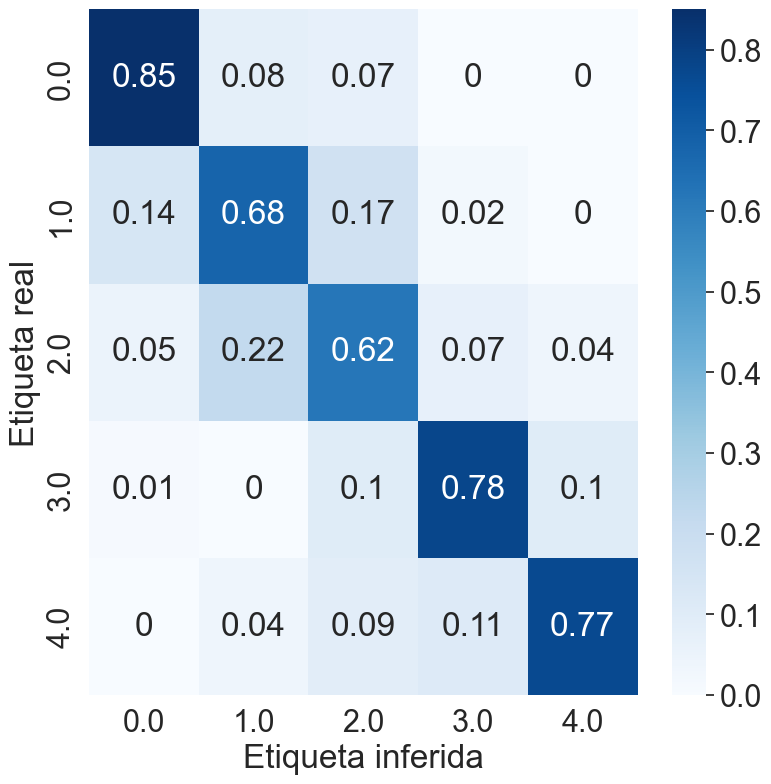

Processing time: 4.354254961013794
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.2235 - loss: 1.6099
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.4023 - loss: 1.4099
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.5911 - loss: 0.9734
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.7598 - loss: 0.7390
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.8015 - loss: 0.6073
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8616 - loss: 0.4865
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.8863 - loss: 0.3935
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.9169 - loss: 0.3213
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.9155 - loss: 0.2762
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.9181 - loss: 0.2538
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.9495 - loss: 0.

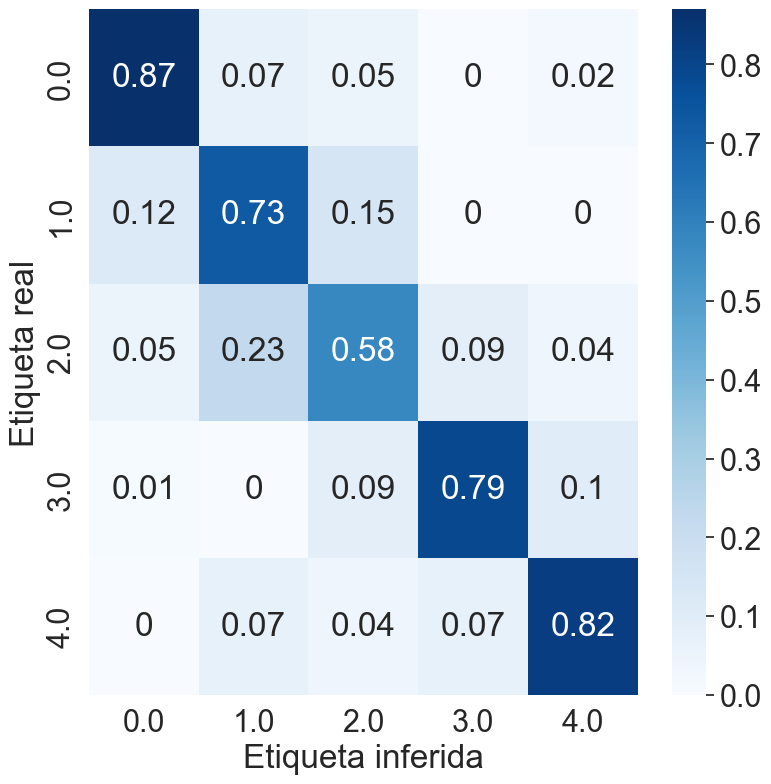

Processing time: 8.143758058547974
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.2443 - loss: 1.6016
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.3984 - loss: 1.4314
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.5353 - loss: 1.1092
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.6368 - loss: 0.8886
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7037 - loss: 0.7964
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7501 - loss: 0.7369
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.7717 - loss: 0.6552
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.7960 - loss: 0.5909
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8446 - loss: 0.5029
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8545 - loss: 0.4715
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.8537 - loss: 0.

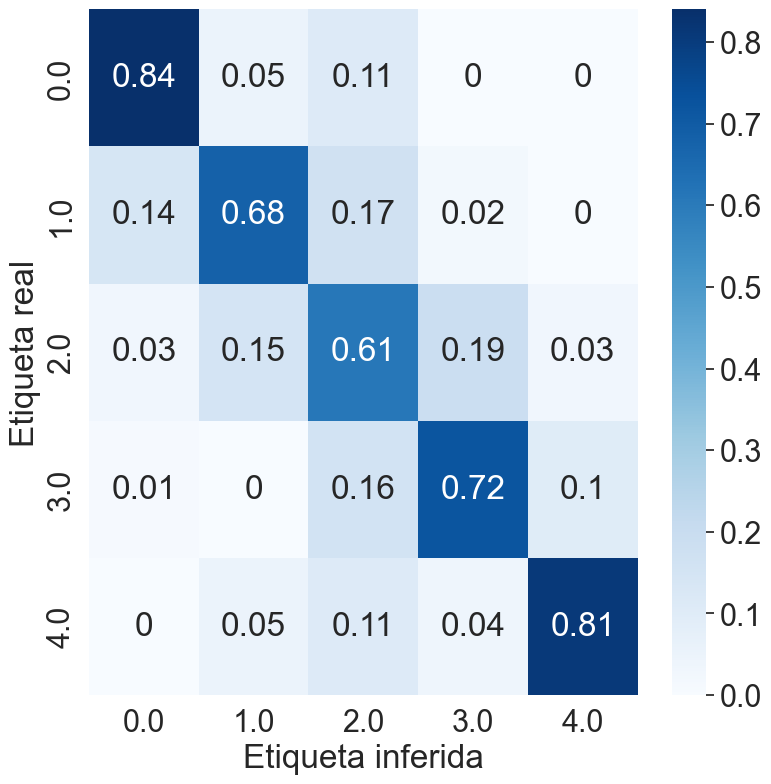

Processing time: 11.96134877204895
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.3192 - loss: 1.5663
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.4887 - loss: 1.2372
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.6414 - loss: 0.9256
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.7140 - loss: 0.8070
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.7851 - loss: 0.6538
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.8141 - loss: 0.5572
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8454 - loss: 0.5043
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.8799 - loss: 0.4030
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.8872 - loss: 0.3660
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.8991 - loss: 0.3270
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.9136 - loss: 0.

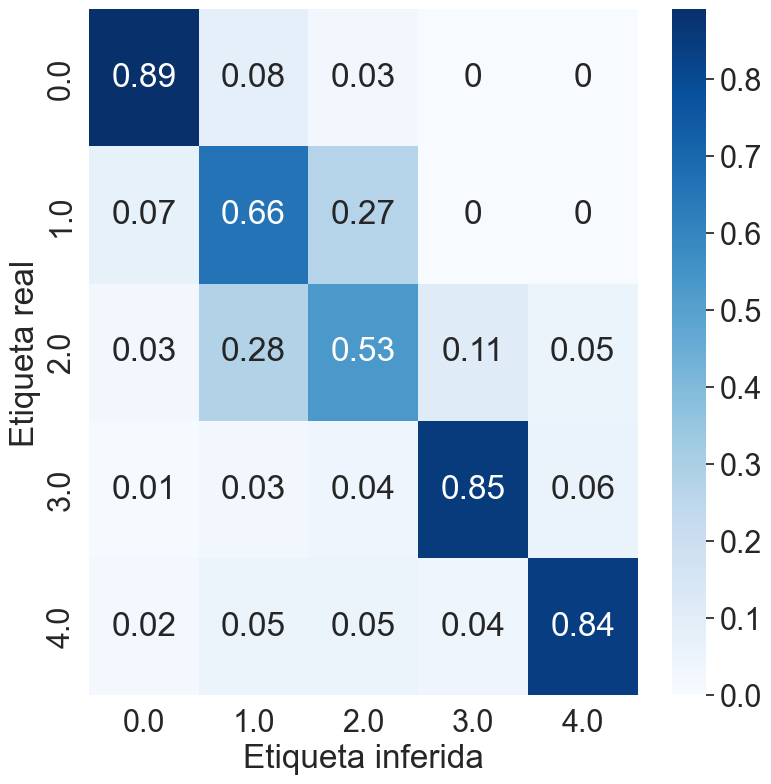

Processing time: 15.846277475357056
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.2274 - loss: 1.8920
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3099 - loss: 1.5756
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.4145 - loss: 1.3699
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5069 - loss: 1.2521
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.5728 - loss: 1.1071
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6142 - loss: 1.0285
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6353 - loss: 0.9693
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6619 - loss: 0.9296
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6981 - loss: 0.8320
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7194 - loss: 0.8101
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.7249 - loss: 0

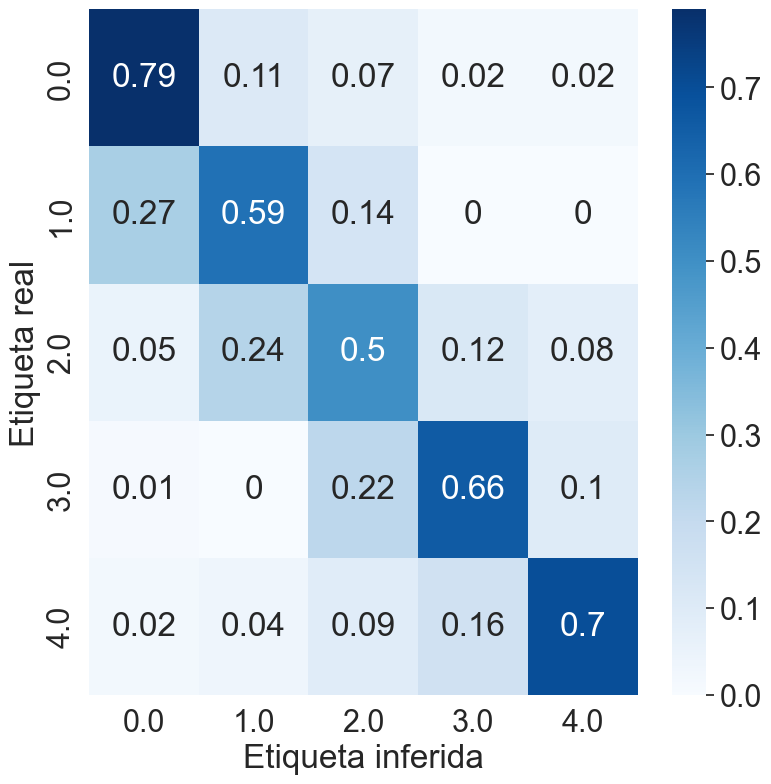

Processing time: 19.058101415634155
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.2197 - loss: 1.8409
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4528 - loss: 1.3735
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5668 - loss: 1.1579
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6139 - loss: 1.0039
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6681 - loss: 0.8887
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6946 - loss: 0.8339
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.7363 - loss: 0.7725
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.7681 - loss: 0.7239
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7809 - loss: 0.6860
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.8007 - loss: 0.6489
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.8125 - loss: 0

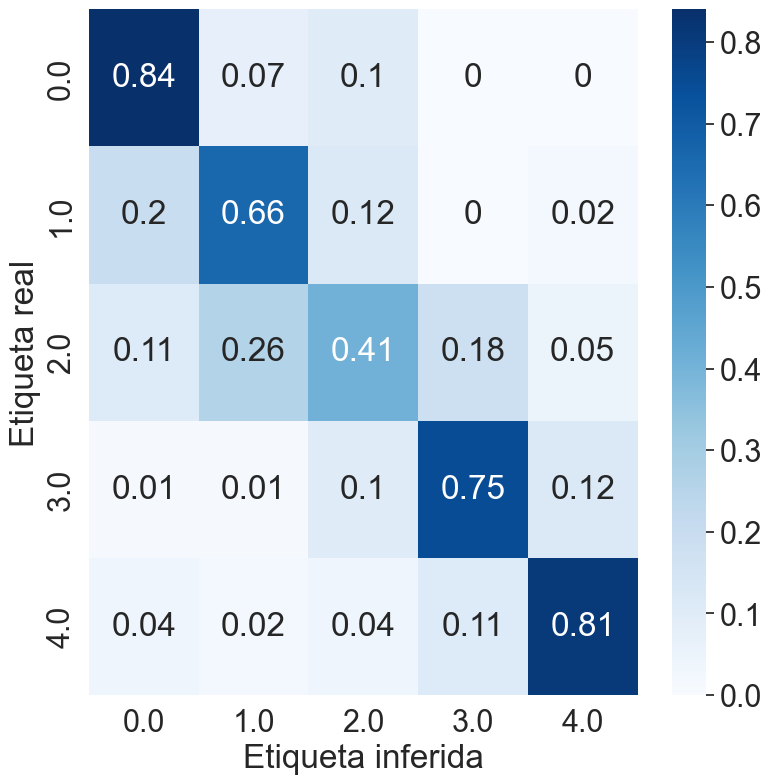

Processing time: 22.280147790908813
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.2863 - loss: 1.6732
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5351 - loss: 1.2185
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6126 - loss: 1.0219
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6932 - loss: 0.8498
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7373 - loss: 0.7765
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7724 - loss: 0.6855
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8050 - loss: 0.6500
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8053 - loss: 0.6076
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.8324 - loss: 0.5556
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.8336 - loss: 0.5215
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.8691 - loss: 0

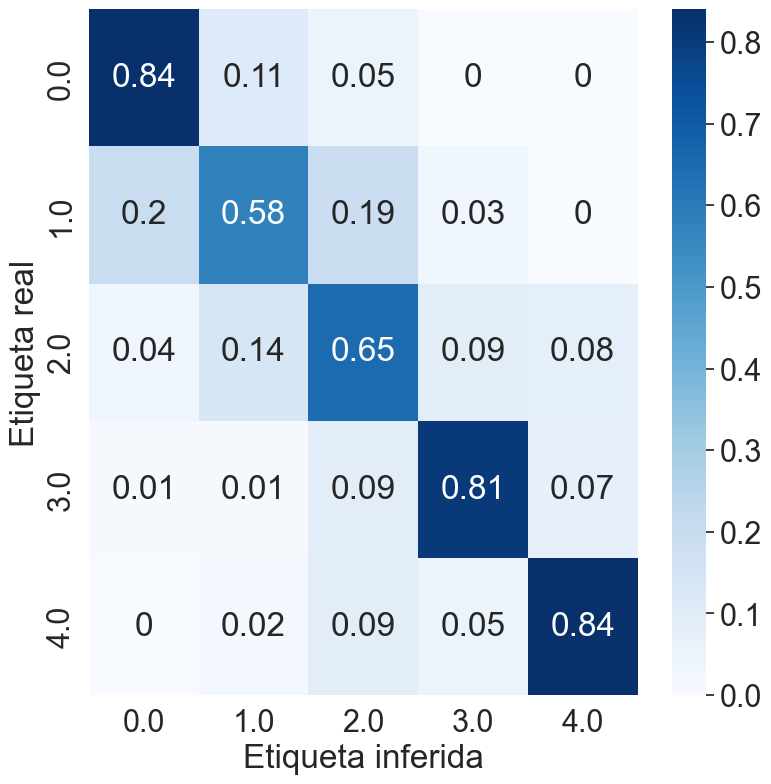

Processing time: 25.809082984924316


In [36]:
main("ANN", "ANN", [1,2,3,4,5,6,7]) #ANN

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 0.91
--------------------------------
[RESULTS] Accuracy: 0.81
[RESULTS] Precision: 0.81
[RESULTS] Recall: 0.81
[RESULTS] F1: 0.81
--------------------------------


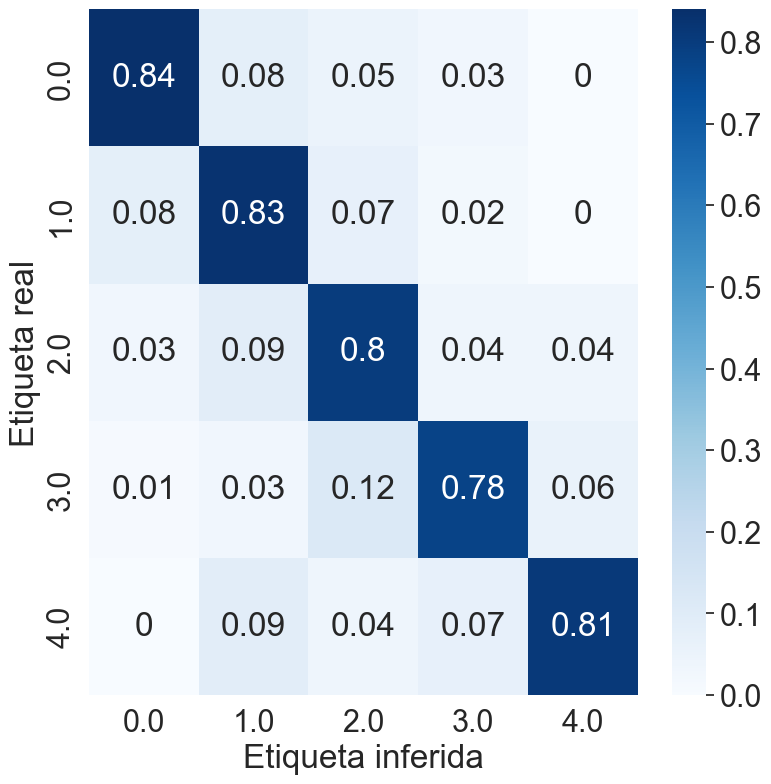

Processing time: 2.012172222137451
[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 0.94
--------------------------------
[RESULTS] Accuracy: 0.82
[RESULTS] Precision: 0.82
[RESULTS] Recall: 0.82
[RESULTS] F1: 0.82
--------------------------------


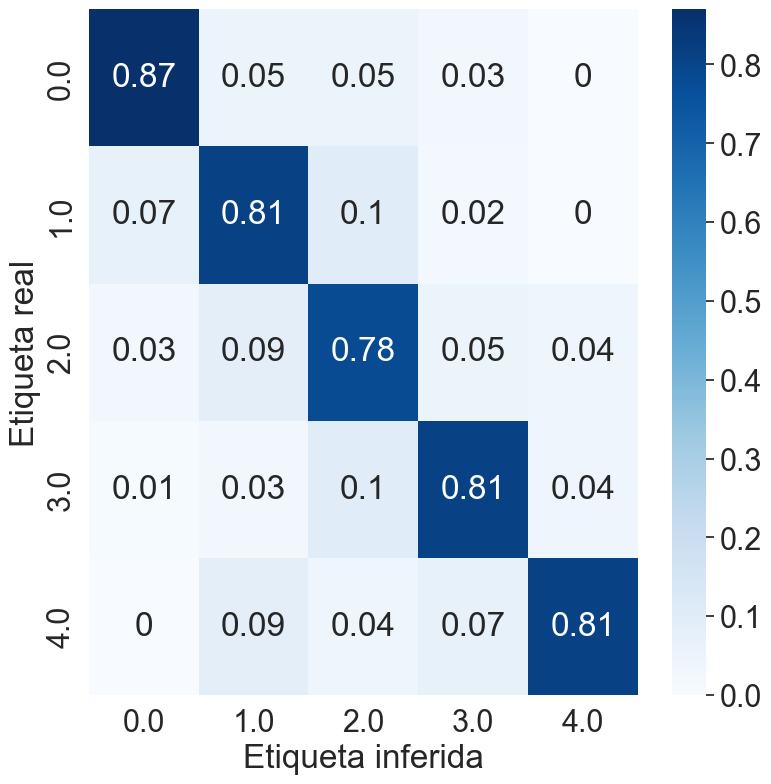

Processing time: 4.534832954406738
[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 0.99
--------------------------------
[RESULTS] Accuracy: 0.83
[RESULTS] Precision: 0.83
[RESULTS] Recall: 0.83
[RESULTS] F1: 0.83
--------------------------------


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


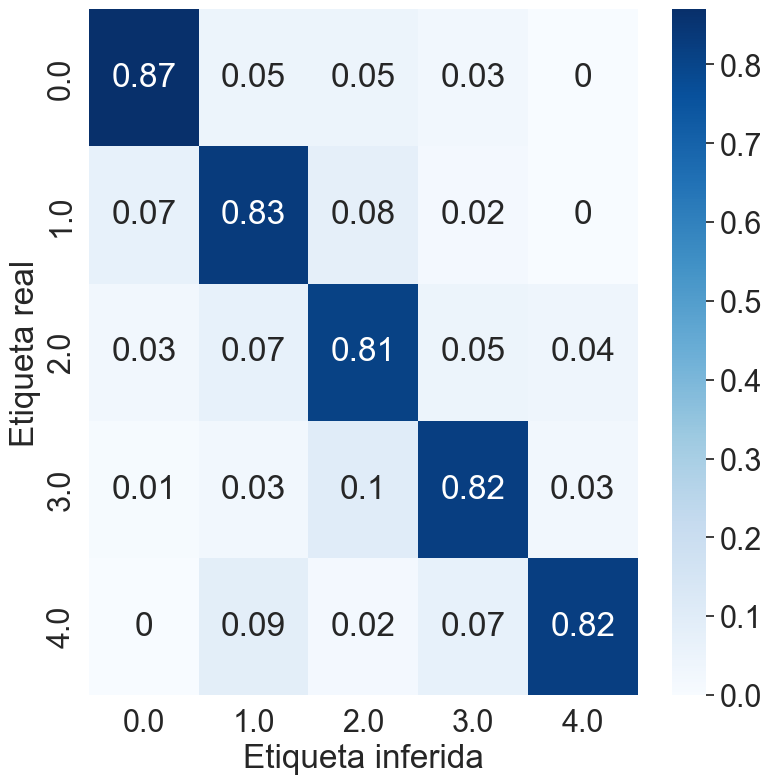

Processing time: 8.07317042350769
[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 0.99
--------------------------------
[RESULTS] Accuracy: 0.82
[RESULTS] Precision: 0.83
[RESULTS] Recall: 0.82
[RESULTS] F1: 0.83
--------------------------------


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


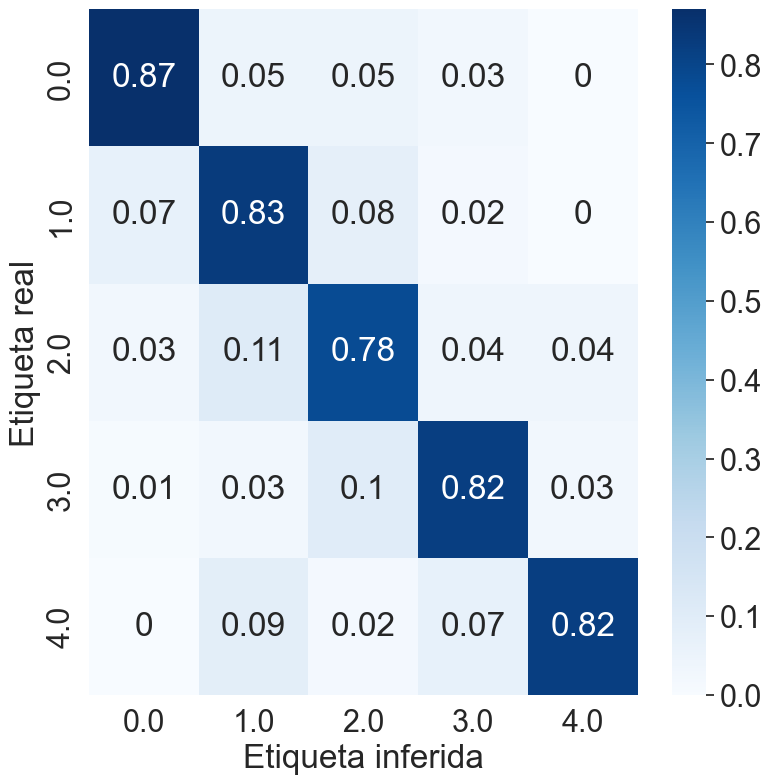

Processing time: 12.363070726394653
[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.83
[RESULTS] Precision: 0.84
[RESULTS] Recall: 0.83
[RESULTS] F1: 0.83
--------------------------------


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


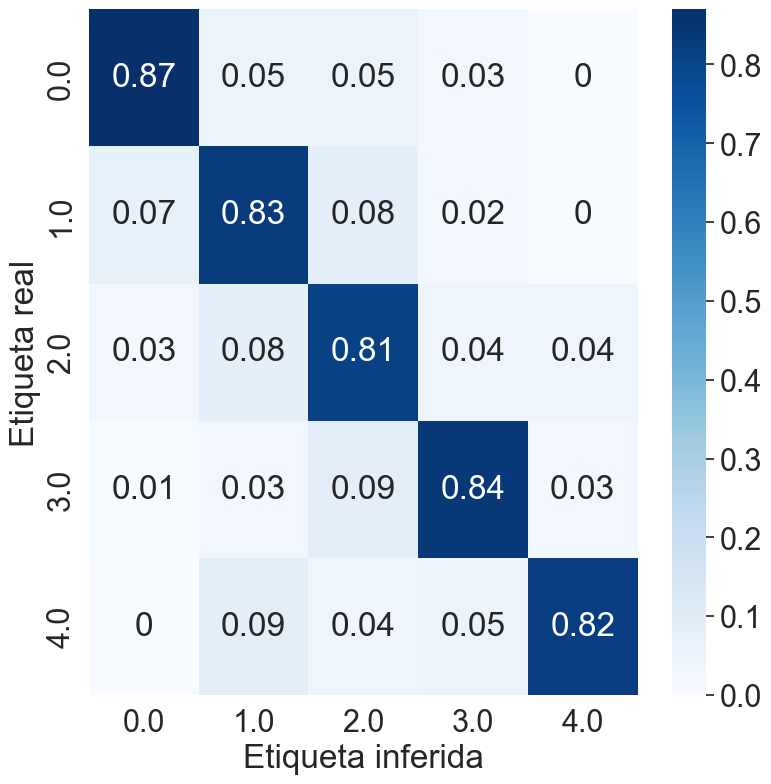

Processing time: 17.05944800376892
[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.84
[RESULTS] Precision: 0.84
[RESULTS] Recall: 0.84
[RESULTS] F1: 0.84
--------------------------------


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


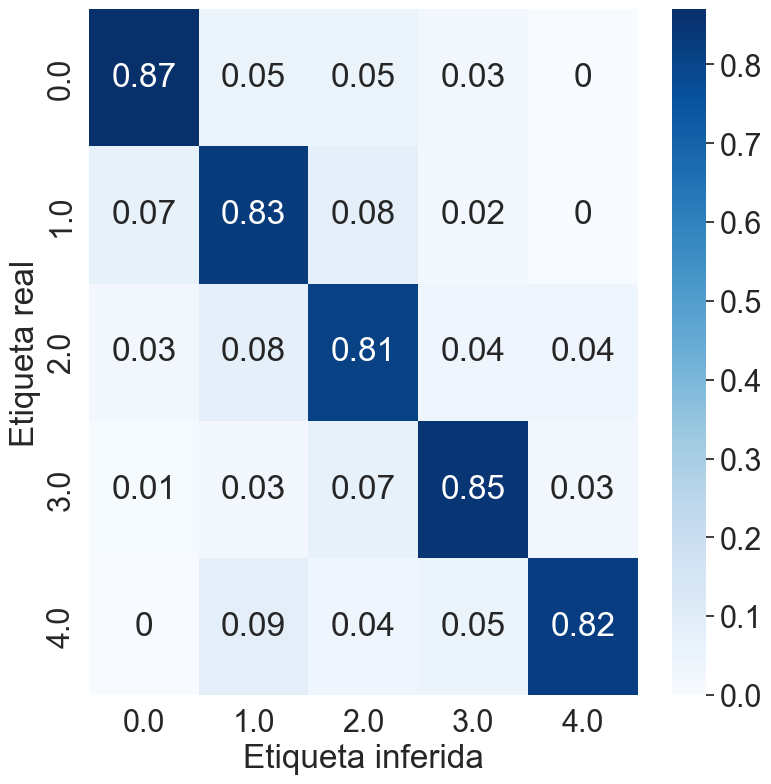

Processing time: 23.170480966567993
[INFO] Training XGBoost.


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.84
[RESULTS] Precision: 0.84
[RESULTS] Recall: 0.84
[RESULTS] F1: 0.84
--------------------------------


c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


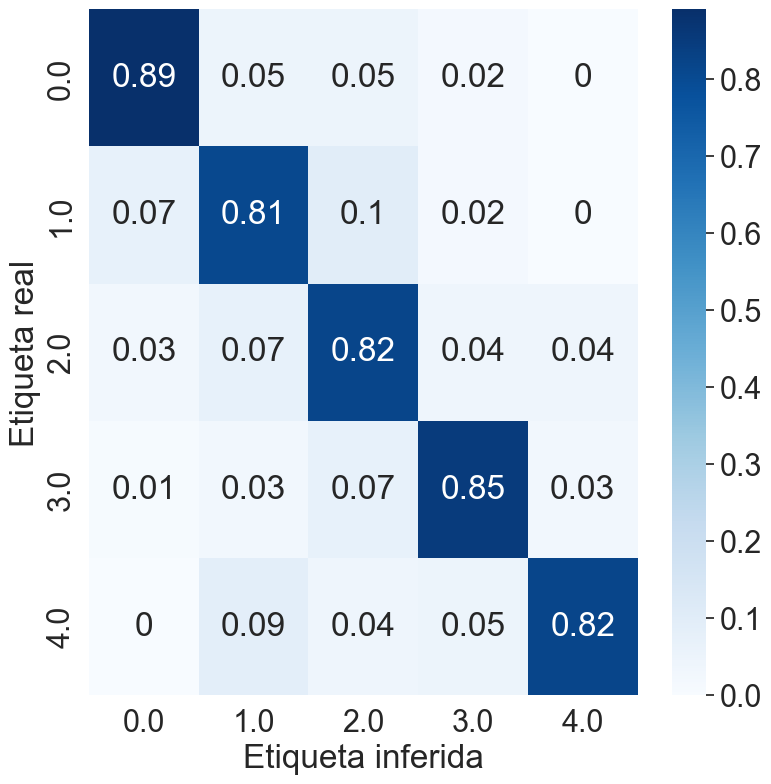

Processing time: 30.182098388671875


In [25]:
main("XGBoost", "XGBoost", [10,30,50,70,100,150,200]) #RF con distintos estimadores

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.81
--------------------------------
[RESULTS] Accuracy: 0.47
[RESULTS] Precision: 0.48
[RESULTS] Recall: 0.47
[RESULTS] F1: 0.47
--------------------------------


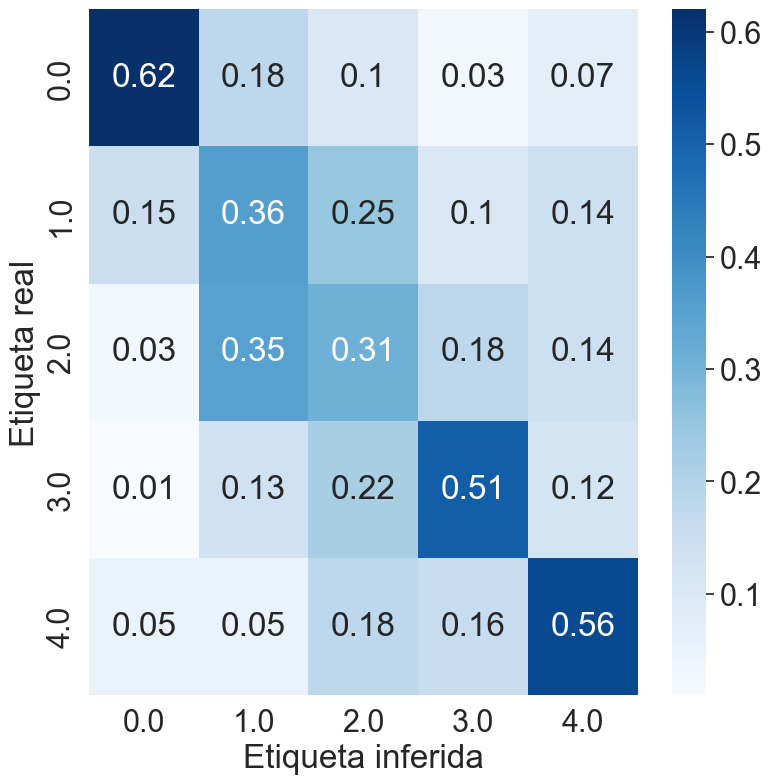

Processing time: 1.7227120399475098
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.97
--------------------------------
[RESULTS] Accuracy: 0.65
[RESULTS] Precision: 0.67
[RESULTS] Recall: 0.65
[RESULTS] F1: 0.65
--------------------------------


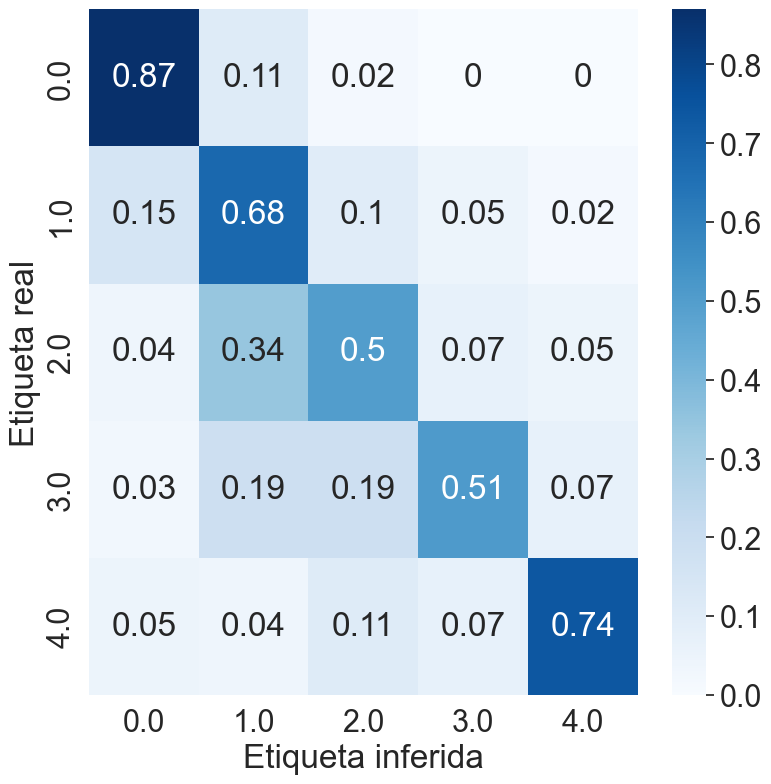

Processing time: 3.35288667678833
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.99
--------------------------------
[RESULTS] Accuracy: 0.70
[RESULTS] Precision: 0.71
[RESULTS] Recall: 0.70
[RESULTS] F1: 0.70
--------------------------------


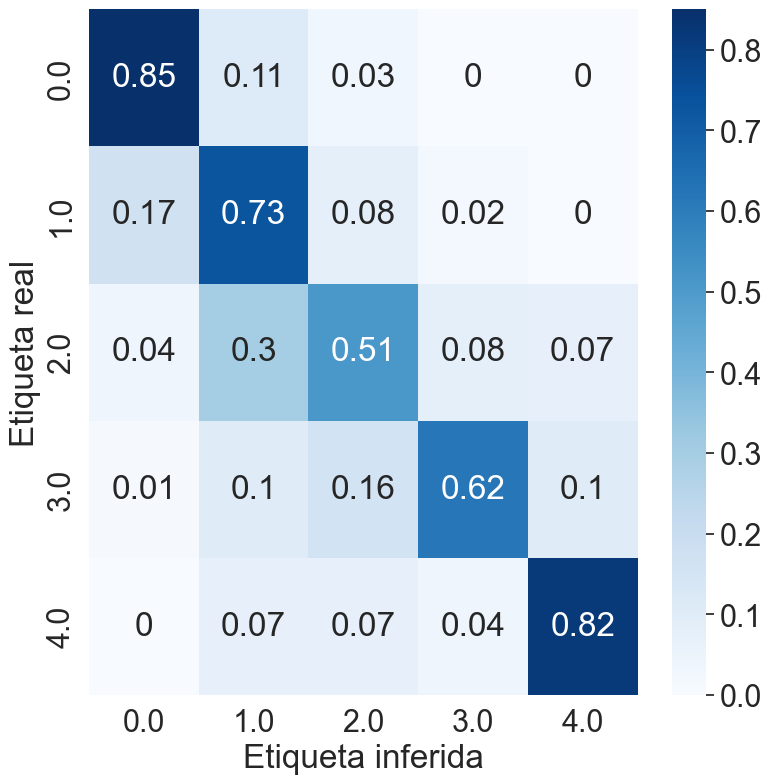

Processing time: 5.006130695343018
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.75
[RESULTS] Precision: 0.76
[RESULTS] Recall: 0.75
[RESULTS] F1: 0.75
--------------------------------


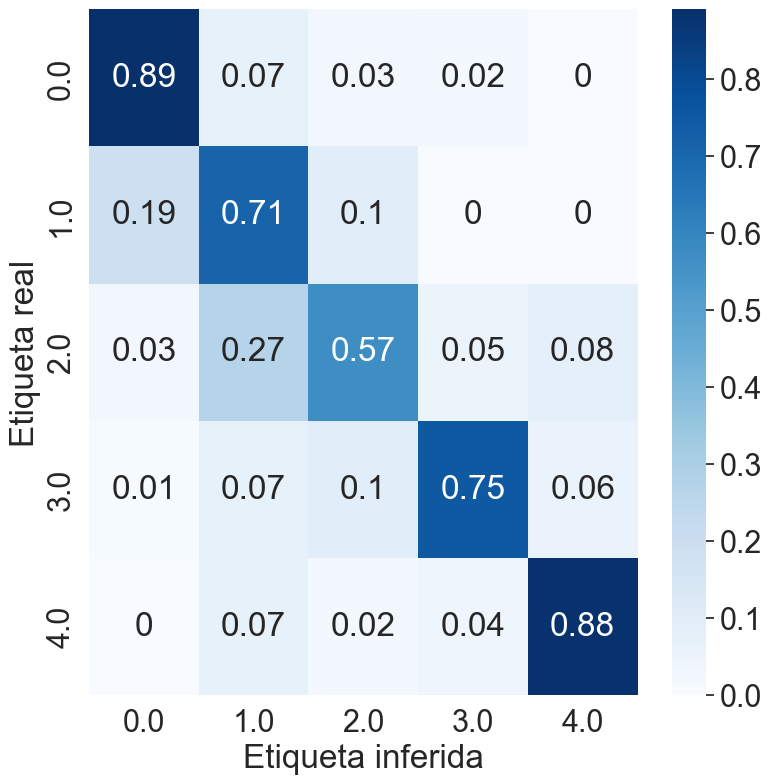

Processing time: 6.702989101409912
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.78
[RESULTS] Precision: 0.79
[RESULTS] Recall: 0.78
[RESULTS] F1: 0.78
--------------------------------


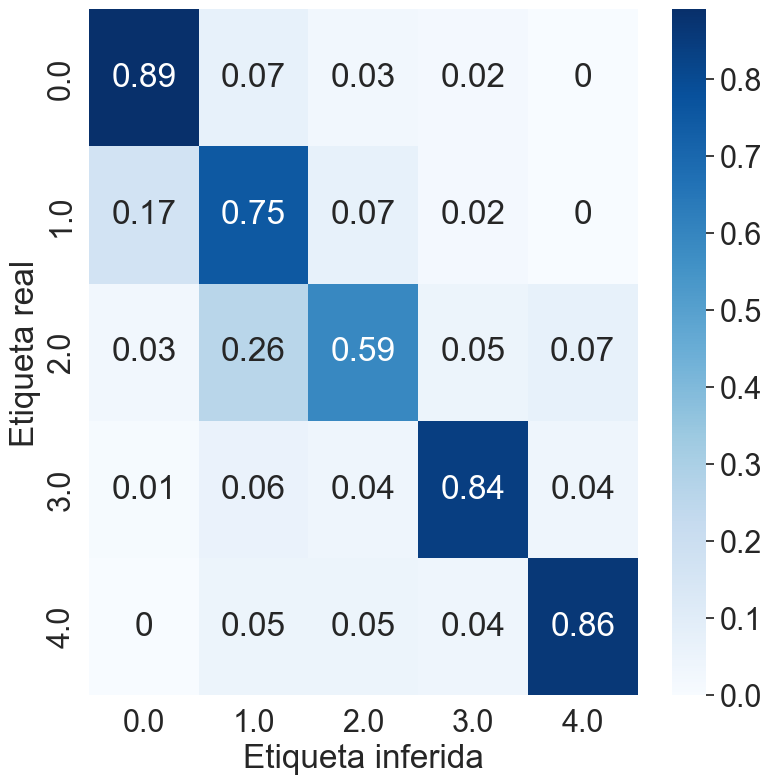

Processing time: 8.422829866409302
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.77
[RESULTS] Precision: 0.78
[RESULTS] Recall: 0.77
[RESULTS] F1: 0.77
--------------------------------


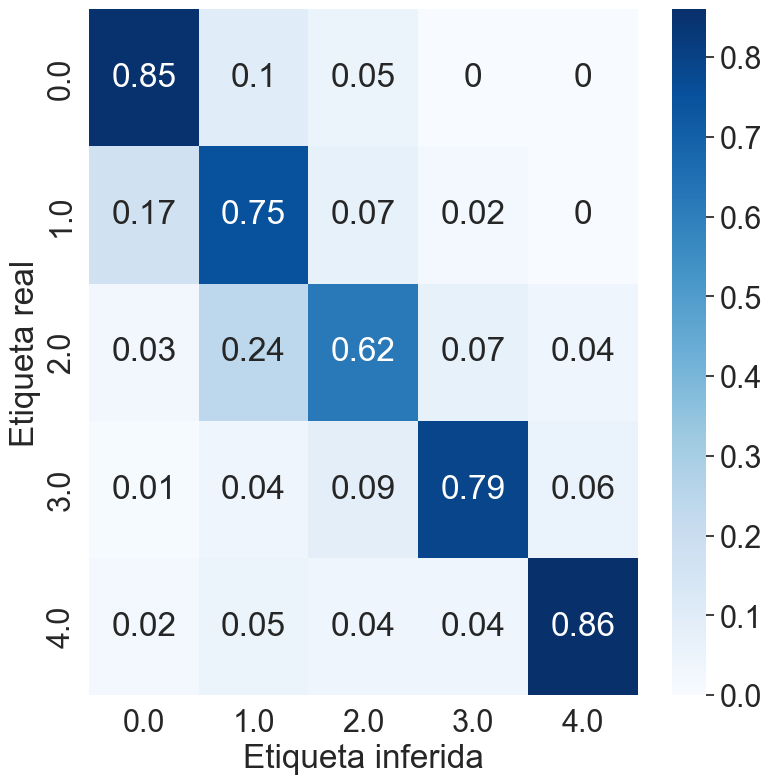

Processing time: 10.19512677192688
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.80
[RESULTS] Precision: 0.81
[RESULTS] Recall: 0.80
[RESULTS] F1: 0.81
--------------------------------


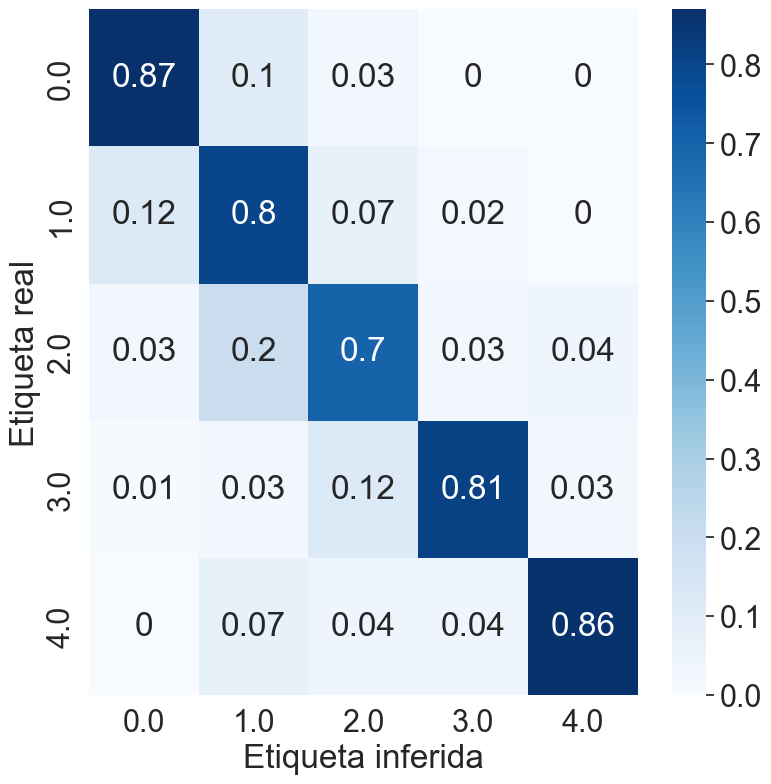

Processing time: 11.982009649276733
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 1.00
--------------------------------
[RESULTS] Accuracy: 0.82
[RESULTS] Precision: 0.83
[RESULTS] Recall: 0.82
[RESULTS] F1: 0.82
--------------------------------


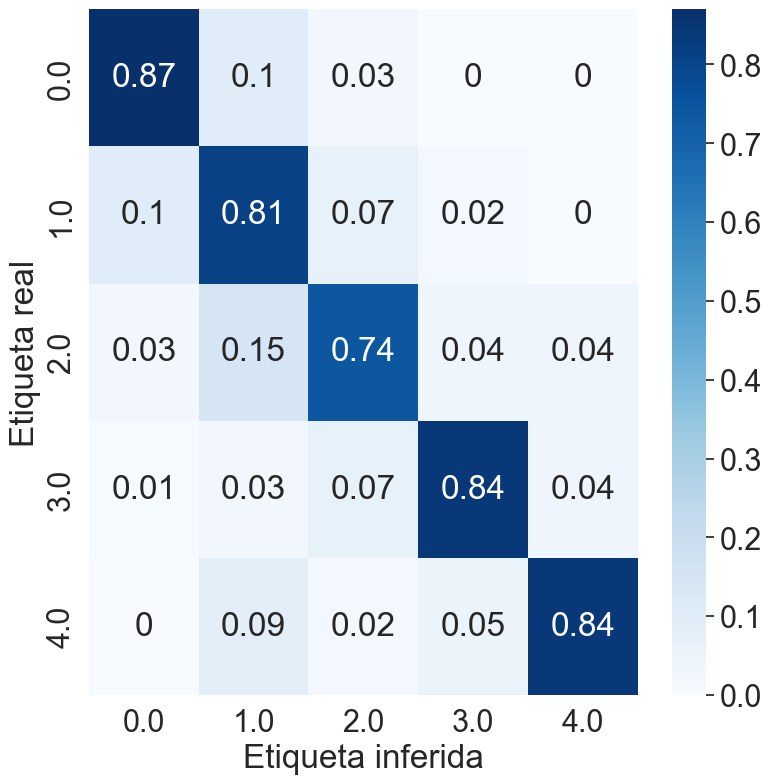

Processing time: 13.776952028274536


In [116]:
main("RF", "RF", [1, 5, 10, 15, 20, 25, 30, 35]) #RF con distintos estimadores

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


[INFO] Training Support Vector Machine model.
[RESULTS] AccuracyTrain: 0.82
--------------------------------
[RESULTS] Accuracy: 0.76
[RESULTS] Precision: 0.76
[RESULTS] Recall: 0.76
[RESULTS] F1: 0.76
--------------------------------


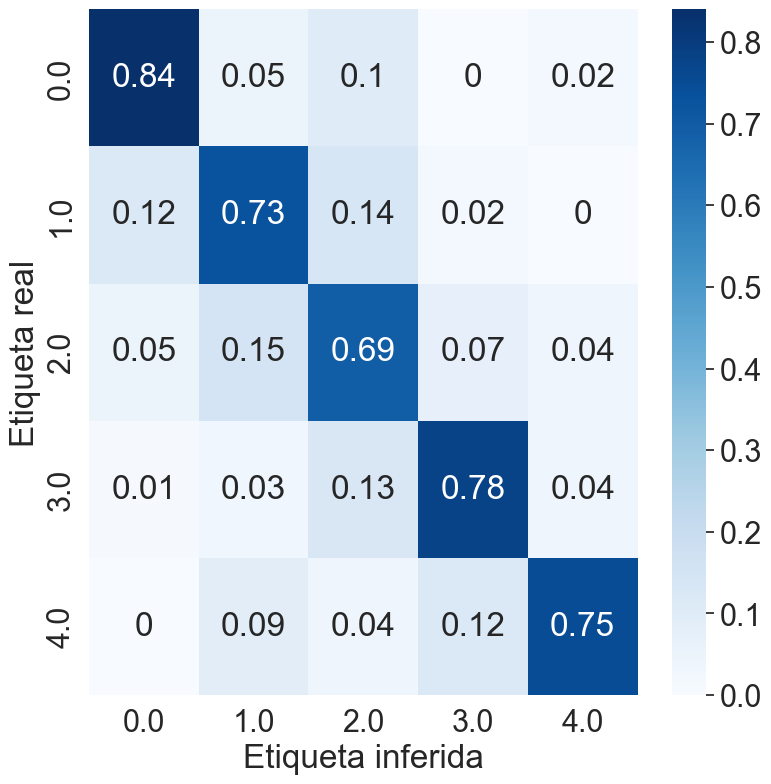

Processing time: 2.20251727104187


In [108]:
main("SVM", "svmLinear") #linear

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


[INFO] Training Support Vector Machine model.
[RESULTS] AccuracyTrain: 0.96
--------------------------------
[RESULTS] Accuracy: 0.71
[RESULTS] Precision: 0.72
[RESULTS] Recall: 0.71
[RESULTS] F1: 0.69
--------------------------------


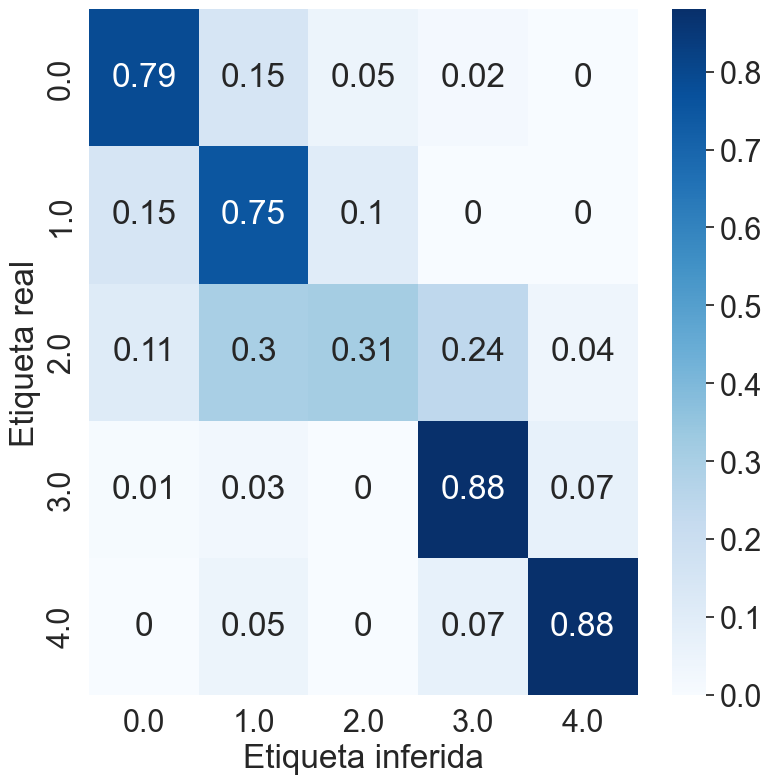

Processing time: 1.738194465637207


In [106]:
main("SVM", "svmPoly") #poly 

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


[INFO] Training Support Vector Machine model.
[RESULTS] AccuracyTrain: 0.62
--------------------------------
[RESULTS] Accuracy: 0.68
[RESULTS] Precision: 0.68
[RESULTS] Recall: 0.68
[RESULTS] F1: 0.68
--------------------------------


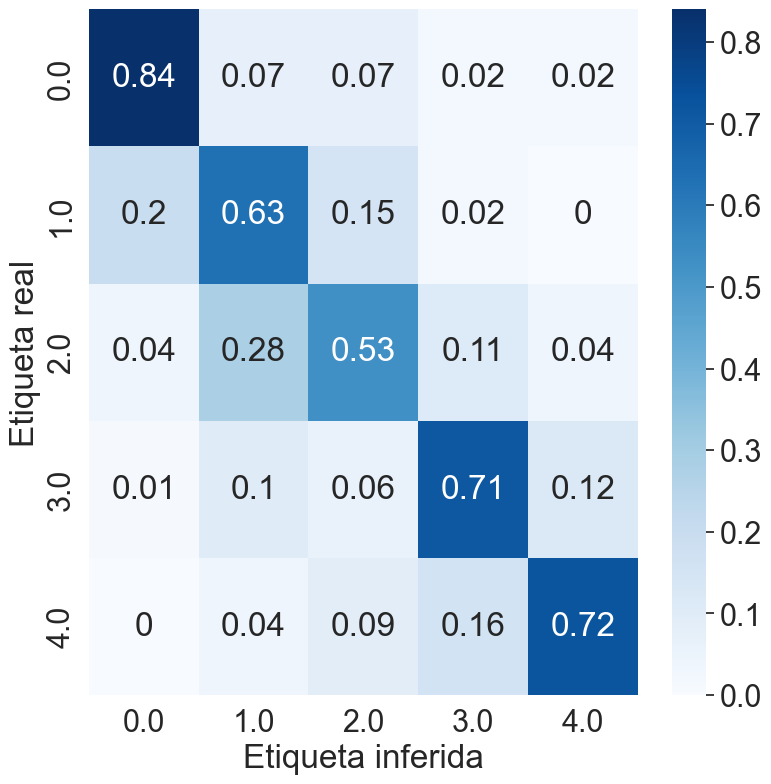

Processing time: 1.7680482864379883


In [103]:
main("SVM", "svmSigmoid") #sigmoid

Distribución de clases en conjunto de datos completo:
clase_fatiga
2.0    319
1.0    232
0.0    212
3.0    190
4.0    168
Name: count, dtype: int64


Distribución de clases en conjunto de datos balanceado:
clase_fatiga
2.0    319
1.0    319
4.0    319
0.0    319
3.0    319
Name: count, dtype: int64


[INFO] Training Support Vector Machine model.
[RESULTS] AccuracyTrain: 0.95
--------------------------------
[RESULTS] Accuracy: 0.77
[RESULTS] Precision: 0.77
[RESULTS] Recall: 0.77
[RESULTS] F1: 0.77
--------------------------------


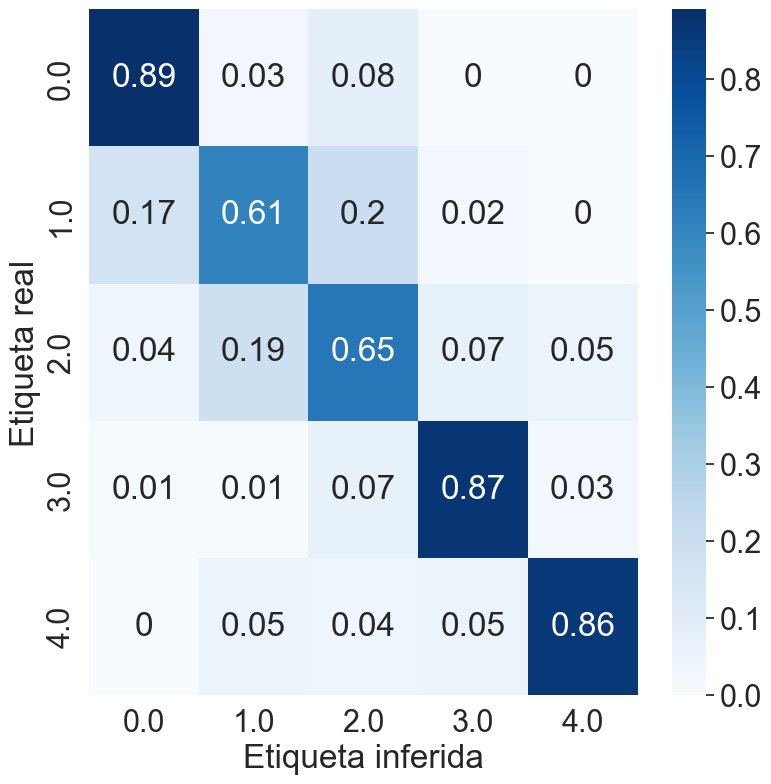

Processing time: 1.8351480960845947


In [101]:
main("SVM", "svmRbf") #rbf

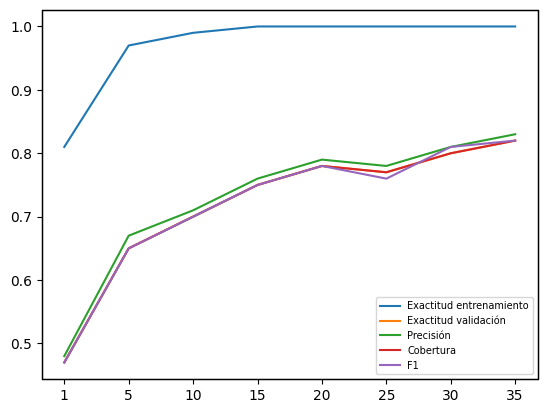

In [4]:
###########################################################################
###########################################################################
###########################################################################
###########################################################################
import matplotlib.pyplot as plt
import time

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

# Configuración de color correcta para las líneas del gráfico
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.grid(False)

NEst = ["1", "5", "10", "15", "20", "25", "30", "35"]
temperaturas = {
    'Acc_T': [0.81, 0.97, 0.99, 1, 1, 1, 1, 1],
    'Acc_Val': [0.47, 0.65, 0.70, 0.75, 0.78, 0.77, 0.80, 0.82],
    'prec': [0.48, 0.67, 0.71, 0.76, 0.79, 0.78, 0.81, 0.83],
    'cob': [0.47, 0.65, 0.70, 0.75, 0.78, 0.77, 0.80, 0.82],
    'f1': [0.47, 0.65, 0.70, 0.75, 0.78, 0.76, 0.81, 0.82]
}

# Dibujando las series de datos
ax.plot(NEst, temperaturas['Acc_T'], label='Exactitud entrenamiento')
ax.plot(NEst, temperaturas['Acc_Val'], label='Exactitud validación')
ax.plot(NEst, temperaturas['prec'], label='Precisión')
ax.plot(NEst, temperaturas['cob'], label='Cobertura')
ax.plot(NEst, temperaturas['f1'], label='F1')

ax.legend(loc='lower right', prop={'size': 7})

# Configuración de color y grosor del borde del área de dibujo
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

# Ajuste del tamaño de fuente de los títulos y etiquetas
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

plt.savefig('RandomForestMetricas.png', dpi=400, transparent=True)
plt.show()

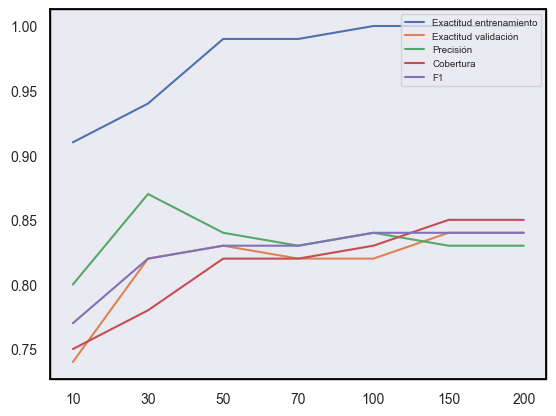

In [27]:
###########################################################################
###########################################################################
###########################################################################
###########################################################################
import matplotlib.pyplot as plt

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
#ax.patch.set_facecolor('0.1')
ax.grid(False)
NEst = ["10", "30", "50", "70", "100", "150", "200"]
temperaturas = {'Acc_T':[0.91, 0.94, 0.99, 0.99, 1,1,1], 'Acc_Val':[0.74, 0.82, 0.83, 0.82, 0.82, 0.84, 0.84], 'prec':[0.80, 0.87, 0.84, 0.83, 0.84, 0.83, 0.83], "cob":[0.75, 0.78, 0.82,0.82, 0.83, 0.85, 0.85], "f1":[0.77, 0.82, 0.83,0.83, 0.84, 0.84, 0.84]}
ax.plot(NEst, temperaturas['Acc_T'], label = 'Exactitud entrenamiento')
ax.plot(NEst, temperaturas['Acc_Val'], label = 'Exactitud validación')
ax.plot(NEst, temperaturas['prec'], label = 'Precisión')
ax.plot(NEst, temperaturas['cob'], label = 'Cobertura')
ax.plot(NEst, temperaturas['f1'], label = 'F1')
ax.legend(loc = 'upper right', prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.savefig('RandomForest.png', dpi=400,  transparent=True)

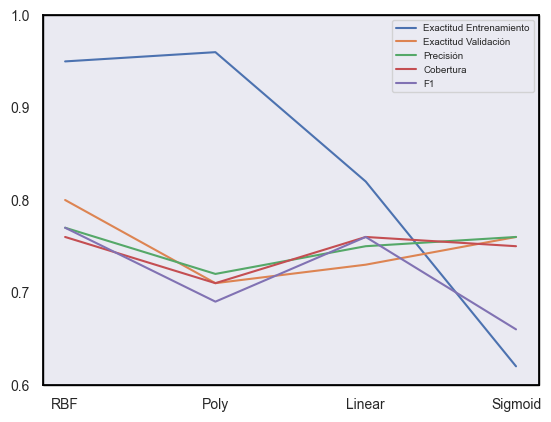

In [30]:
###########################################################################
###########################################################################
###########################################################################
###########################################################################
import matplotlib.pyplot as plt
import numpy as np

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

# Aseguramos que los colores sean valores numéricos válidos
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(False)

NEst = ["RBF", "Poly", "Linear", "Sigmoid"]
temperaturas = {
    'Acc_T': [0.95,0.96,0.82,0.62],
    'Acc_Val': [0.8, 0.71, 0.73, 0.76],
    'prec': [0.77, 0.72, 0.75, 0.76],
    'cob': [0.76, 0.71, 0.76, 0.75],
    'f1': [0.77, 0.69, 0.76, 0.66]
}

ax.plot(NEst, temperaturas['Acc_T'], label='Exactitud Entrenamiento')
ax.plot(NEst, temperaturas['Acc_Val'], label='Exactitud Validación')
ax.plot(NEst, temperaturas['prec'], label='Precisión')
ax.plot(NEst, temperaturas['cob'], label='Cobertura')
ax.plot(NEst, temperaturas['f1'], label='F1')
ax.legend(loc='upper right', prop={'size': 7})

ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
ax.set_ylim(0.6, 1.0)

plt.savefig('SVM.png', dpi=400, transparent=True)
plt.show()

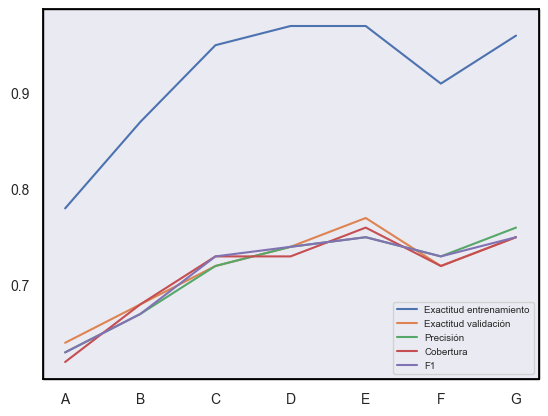

In [38]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
#ax.patch.set_facecolor('0.1')
ax.grid(False)
NEst = ["A", "B", "C", "D", "E", "F", "G"]
temperaturas = {
    'Acc_T': [0.78, 0.87, 0.95, 0.97, 0.97, 0.91, 0.96],
    'Acc_Val': [0.64, 0.68, 0.72, 0.74, 0.77, 0.72, 0.75],
    'prec': [0.63, 0.67, 0.72, 0.74, 0.75, 0.73, 0.76],
    'cob': [0.62, 0.68, 0.73, 0.73, 0.76, 0.72, 0.75],
    'f1': [0.63, 0.67, 0.73, 0.74, 0.75, 0.73, 0.75]
}
ax.plot(NEst, temperaturas['Acc_T'], label = 'Exactitud entrenamiento')
ax.plot(NEst, temperaturas['Acc_Val'], label = 'Exactitud validación')
ax.plot(NEst, temperaturas['prec'], label = 'Precisión')
ax.plot(NEst, temperaturas['cob'], label = 'Cobertura')
ax.plot(NEst, temperaturas['f1'], label = 'F1')
ax.legend(loc = 'lower right', prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.savefig('ANN.png', dpi=400,  transparent=True)
plt.show()

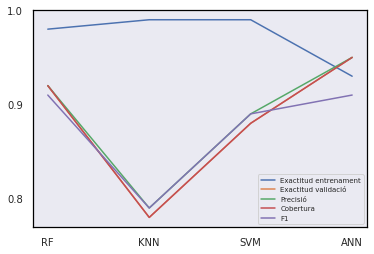

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
#ax.patch.set_facecolor('0.1')
ax.grid(False)
NEst = ["RF", "KNN", "SVM", "ANN"]
temperaturas = {'Acc_T':[0.98, 0.99, 0.99, 0.93], 'Acc_Val':[0.92, 0.78, 0.88, 0.95], 'prec':[0.92, 0.79, 0.89, 0.95], "cob":[0.92, 0.78, 0.88, 0.95], "f1":[0.91, 0.79, 0.89, 0.91]}
ax.plot(NEst, temperaturas['Acc_T'], label = 'Exactitud entrenament')
ax.plot(NEst, temperaturas['Acc_Val'], label = 'Exactitud validació')
ax.plot(NEst, temperaturas['prec'], label = 'Precisió')
ax.plot(NEst, temperaturas['cob'], label = 'Cobertura')
ax.plot(NEst, temperaturas['f1'], label = 'F1')
ax.legend(loc = 'lower right', prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.savefig('blau1.png', dpi=400,  transparent=True)
plt.show()

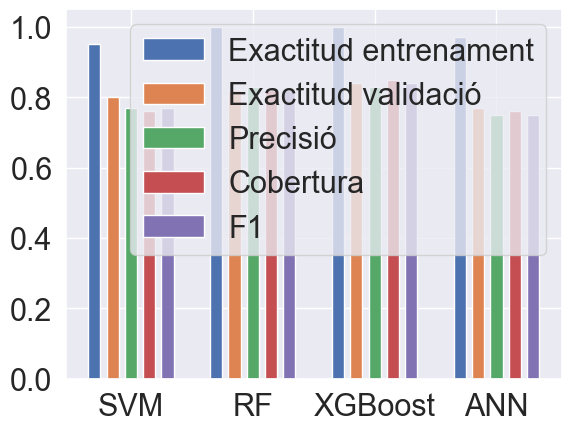

In [39]:
# Import Library

import numpy as np
import matplotlib.pyplot as plt

# Define Data

team = ['SVM','RF','XGBoost','ANN']
female = [5, 10, 15, 20, 25]
male = [15, 20, 30, 16, 13]
temperaturas = {'Acc_T':[0.95, 1, 1, 0.97],
                'Acc_Val':[0.8, 0.82, 0.84, 0.77], 
                'prec':[0.77, 0.83, 0.83, 0.75], 
                "cob":[0.76, 0.82, 0.85, 0.76], 
                "f1":[0.77, 0.82, 0.84, 0.75]}
x_axis = np.arange(len(team))

# Multi bar Chart

#plt.bar(x_axis -0.2, female, width=0.4, label = 'Female')
#plt.bar(x_axis +0.2, male, width=0.4, label = 'Male')
plt.bar(x_axis - 0.3, temperaturas['Acc_T'],width=0.1, label = 'Exactitud entrenament')
plt.bar(x_axis -0.15, temperaturas['Acc_Val'],width=0.1, label = 'Exactitud validació')
plt.bar(x_axis, temperaturas['prec'],width=0.1, label = 'Precisió')
plt.bar(x_axis+0.15, temperaturas['cob'],width=0.1, label = 'Cobertura')
plt.bar(x_axis+0.30, temperaturas['f1'],width=0.1, label = 'F1')

# Xticks

plt.xticks(x_axis, team)

# Add legend

plt.legend()

# Display

plt.show()

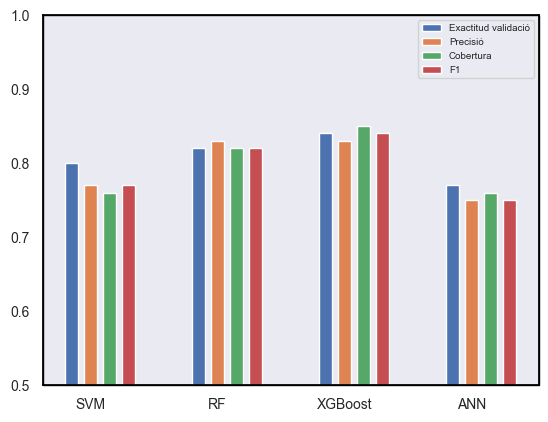

In [49]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
#ax.patch.set_facecolor('0.1')
ax.grid(False)
NEst = ["RF", "KNN", "SVM", "ANN"]
temperaturas = {'Acc_T':[0.98, 0.99, 0.99, 0.93], 'Acc_Val':[0.92, 0.78, 0.88, 0.95], 'prec':[0.92, 0.79, 0.89, 0.95], "cob":[0.92, 0.78, 0.88, 0.95], "f1":[0.91, 0.79, 0.89, 0.91]}
team = ['SVM','RF','XGBoost','ANN']
female = [5, 10, 15, 20, 25]
male = [15, 20, 30, 16, 13]
temperaturas = {'Acc_Val':[0.8, 0.82, 0.84, 0.77], 
                'prec':[0.77, 0.83, 0.83, 0.75], 
                "cob":[0.76, 0.82, 0.85, 0.76], 
                "f1":[0.77, 0.82, 0.84, 0.75]}
x_axis = np.arange(len(team))

# Multi bar Chart

#plt.bar(x_axis -0.2, female, width=0.4, label = 'Female')
#plt.bar(x_axis +0.2, male, width=0.4, label = 'Male')
#plt.bar(x_axis - 0.3, temperaturas['Acc_T'],width=0.1, label = 'Exactitud entrenament')
plt.bar(x_axis -0.15, temperaturas['Acc_Val'],width=0.1, label = 'Exactitud validació')
plt.bar(x_axis, temperaturas['prec'],width=0.1, label = 'Precisió')
plt.bar(x_axis+0.15, temperaturas['cob'],width=0.1, label = 'Cobertura')
plt.bar(x_axis+0.30, temperaturas['f1'],width=0.1, label = 'F1')
ax.legend(loc = 'upper right', prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)
plt.ylim(ymin=0.5, ymax = 1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.xticks(x_axis, team)
plt.savefig('ModelosGenerales.png', dpi=400,  transparent=True)
plt.show()

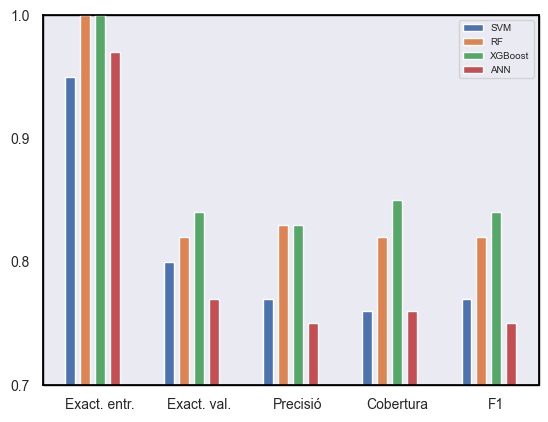

In [45]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

fig, ax = plt.subplots()

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
#ax.patch.set_facecolor('0.1')
ax.grid(False)
NEst = ["Exact. entr.", "Exact. val.", "Precisión",'Cobertura', "F1"]
#temperaturas = {'Acc_T':[0.98, 0.99, 0.99, 0.93], 'Acc_Val':[0.92, 0.78, 0.88, 0.95], 'prec':[0.92, 0.79, 0.89, 0.95], "cob":[0.92, 0.78, 0.88, 0.95], "f1":[0.91, 0.79, 0.89, 0.91]}
temperaturas = {'SVM':[0.95, 0.8, 0.77,0.76, 0.77], 'RF':[1, 0.82, 0.83, 0.82, 0.82], 'XGBoost':[1, 0.84, 0.83, 0.85, 0.84], "ANN":[0.97, 0.77, 0.75, 0.76, 0.75]}
team = ["Exact. entr.", "Exact. val.", "Precisió",'Cobertura', "F1"]

#temperaturas = {'Acc_T':[0.98, 0.99, 0.99, 0.93], 'Acc_Val':[0.92, 0.78, 0.88, 0.95], 'prec':[0.92, 0.79, 0.89, 0.95], "cob":[0.92, 0.78, 0.88, 0.95], "f1":[0.91, 0.79, 0.89, 0.91]}
x_axis = np.arange(len(team))

# Multi bar Chart

#plt.bar(x_axis -0.2, female, width=0.4, label = 'Female')
#plt.bar(x_axis +0.2, male, width=0.4, label = 'Male')
plt.bar(x_axis - 0.3, temperaturas['SVM'],width=0.1, label = 'SVM')
plt.bar(x_axis -0.15, temperaturas['RF'],width=0.1, label = 'RF')
plt.bar(x_axis, temperaturas['XGBoost'],width=0.1, label = 'XGBoost')
plt.bar(x_axis+0.15, temperaturas['ANN'],width=0.1, label = 'ANN')
#plt.bar(x_axis+0.30, temperaturas['f1'],width=0.1, label = 'F1')
ax.legend(loc = 'upper right', prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)
plt.ylim(ymin=0.7, ymax = 1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.xticks(x_axis, team)
plt.savefig('MetricasGenerales.png', dpi=400,  transparent=True)
plt.show()

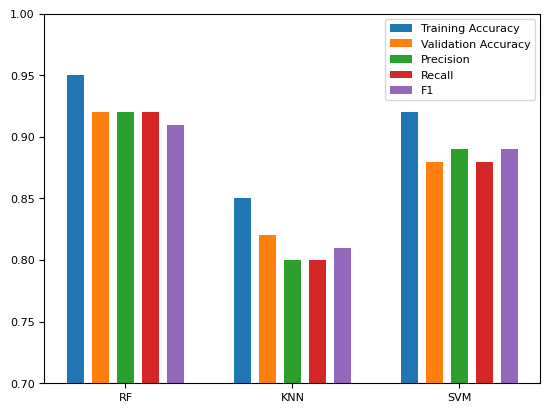

In [ ]:
# Import Library

import numpy as np
import matplotlib.pyplot as plt

# Define Data

team = ['RF','KNN','SVM']
female = [5, 10, 15, 20, 25]
male = [15, 20, 30, 16, 13]
temperaturas = {'Acc_T':[0.95, 0.85, 0.92], 'Acc_Val':[0.92, 0.82, 0.88], 'prec':[0.92, 0.80, 0.89], "cob":[0.92, 0.80, 0.88], "f1":[0.91, 0.81, 0.89]}
#team = ["Exact. entr.", "Exact. val.", "Precisió",'Cobertura', "F1"]
x_axis = np.arange(len(team))

# Multi bar Chart

#plt.bar(x_axis -0.2, female, width=0.4, label = 'Female')
#plt.bar(x_axis +0.2, male, width=0.4, label = 'Male')
plt.bar(x_axis - 0.3, temperaturas['Acc_T'],width=0.1, label = 'Training Accuracy')
plt.bar(x_axis -0.15, temperaturas['Acc_Val'],width=0.1, label = 'Validation Accuracy')
plt.bar(x_axis, temperaturas['prec'],width=0.1, label = 'Precision')
plt.bar(x_axis+0.15, temperaturas['cob'],width=0.1, label = 'Recall')
plt.bar(x_axis+0.30, temperaturas['f1'],width=0.1, label = 'F1')

# Xticks

plt.xticks(x_axis, team)

# Add legend

plt.legend()
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')
plt.ylim(ymin=0.7, ymax = 1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.xticks(x_axis, team)
plt.savefig('blau1.png', dpi=400,  transparent=True)
# Display

plt.show()